In [40]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

This notebook uses the TMDB5000 dataset from Kaggle (https://www.kaggle.com/tmdb/tmdb-movie-metadata)

In [41]:
# Read in movie metadata
movie_df = pd.read_csv('TMDB5000/tmdb_5000_movies.csv')

In [42]:
# Normalize popularity score with MinMax scaler
movie_df['popularity_scaled'] = MinMaxScaler().fit_transform(movie_df.popularity.values.reshape(-1, 1))

## Preprocessing

In [43]:
# Lowercase, remove numerical characters, punctuations, double-space
def preprocess(text):
    text = str(text)
    text = text.lower()
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^\w\s]','',text)
    text = text.replace('  ',' ')
    return text
    
movie_df.overview = movie_df.overview.apply(preprocess)

## Create TFIDF matrix
Term Frequency - Inverse Document Frequency (TD-IDF) measures how relevant a words is to a particular document in a whole lot of documents. TDIDF is a simple algorithm and is explained by a simple formula below

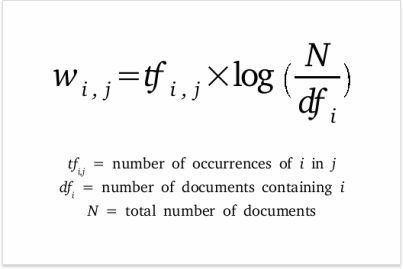

The algorithm eliminates the effect of common words that are prevalent in a lot of documents, such as pronouns, which don't carry much meaning. 

**Case in point:** \
Let's say there's we are calculating the score of the word 'is' in a particular document in which the word appeared 10 times, giving us:

*tf(i,j) = 10;*

There's 1,000 documents and each document contains the word 'is', giving us:

*N = 1000*\
*df(i) = 1000*

**score = 10*log(1000/1000) = 0**

The weight/score given to the word 'is' is zero. In fact, it doesn't matter how many times the word appeared in the particular document we are looking at, **as long as we know the word appears in every single document, we know the the word is meaningless and log(1) always equals to 0.**

In [44]:
# Define the max_features, max_df, min_df
max_features = None # the top n vocabularies
max_df = 0.9 # ignore words that appear in 90% of the documents

# Create an n_sample*max_features matrix
vectorizer = TfidfVectorizer(analyzer='word', 
                             stop_words='english', 
                             max_features=max_features,
                             max_df=max_df) 

X = vectorizer.fit_transform(movie_df.overview)

In [45]:
X

<4803x22854 sparse matrix of type '<class 'numpy.float64'>'
	with 124356 stored elements in Compressed Sparse Row format>

A 4803x22854 matrix, meaning there's 22854 unique tokens in the corpus!

## Calculate Cosine similarity

Cosine similarity is the cosine of the angle between two n-dimensional vectors. It is the dot product of the two vectors divided by the product of the two vectors' lengths. It gives us an idea of how similar two vectors are.

1. Convert the query into a vector in the dimension of the 'pre_trained' vectorizer 
2. Calculate the cosine similarity of the query and the documents, and then multiply by a scaler which is the movie's relative popularity so that given the same similarity scores, the more popular one will be prioritized
3. Sort the similarities and return the top-n similar documents in indices 
4. Show the movie names by the indices

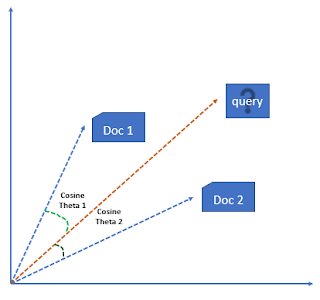 (https://www.r-bloggers.com/2017/11/information-retrieval-document-search-using-vector-space-model-in-r/)

The above gives a simple illustration of how cosine similarity works, although it would be difficult to visualize the concept at higher dimensions.

In [46]:
def cal_similarity(X, query, vectorizer, top=5):
    vector = vectorizer.transform(query)
    similarity = cosine_similarity(X, vector).flatten()*(movie_df.popularity_scaled.values+1)
    top_sim_scores = np.sort(similarity)[-top:][::-1]
    indices = np.argsort(similarity, axis=0)[-top:][::-1]
    for movie, score in zip(movie_df.original_title[indices].to_list(), top_sim_scores):
        print(movie)

In [47]:
query = ['harry potter']
cal_similarity(X, query, vectorizer, top=5)

Harry Potter and the Philosopher's Stone
Harry Potter and the Goblet of Fire
Dude Where's My Dog?
Harry Potter and the Prisoner of Azkaban
Harry Potter and the Order of the Phoenix


## TDIDF Applications

There are two key applications of the TDIDF algorithm, including:
1. Document retrieval & search - as shown above, with just a few words we can quickly identify the similar content in the corpus
2. Recommender system - since we can calculate the cosine similarity of any two pieces of text, we can apply it on a content-based recommender system. E.g. in news website, there's a 'See Similar' section which suggests similar news (i.e. documents) based on the current news you are reading (i.e. the document)